# Endogenous Grid Method


```{include} _admonition/gpu.md
```

## Overview

In this lecture we use the endogenous grid method (EGM) to solve a basic income
fluctuation (optimal savings) problem.

Background on the endogenous grid method can be found in [an earlier
QuantEcon lecture](https://python.quantecon.org/egm_policy_iter.html).

Here we focus on providing an efficient JAX implementation.

We will use the following libraries and imports.

In [1]:
!pip install --upgrade quantecon

In [2]:
import quantecon as qe
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
import numba

Let's check the GPU we are running

In [3]:
!nvidia-smi

/opt/conda/envs/quantecon/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Thu Mar 14 01:42:01 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.182.03   Driver Version: 470.182.03   CUDA Version: 12.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|


|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   30C    P0    37W / 300W |      0MiB / 16160MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU   GI   CI        PID   Type   Process name                  GPU Memory |
|        ID   ID                                                   Usage      |
|=============================================================================|
|  No running processes found                                                 |
+-----------------------------------------------------------------------------+


We use 64 bit floating point numbers for extra precision.

In [4]:
jax.config.update("jax_enable_x64", True)

## Setup 

We consider a household that chooses a state-contingent consumption plan $\{c_t\}_{t \geq 0}$ to maximize

$$
\mathbb{E} \, \sum_{t=0}^{\infty} \beta^t u(c_t)
$$

subject to

$$
    a_{t+1} \leq  R(a_t - c_t)  + Y_{t+1},
    \quad c_t \geq 0,
    \quad a_t \geq 0
    \quad t = 0, 1, \ldots
$$

Here $R = 1 + r$ where $r$ is the interest rate.

The income process $\{Y_t\}$ is a [Markov chain](https://python.quantecon.org/finite_markov.html) generated by stochastic matrix $P$.

The matrix $P$ and the grid of values taken by $Y_t$ are obtained by
discretizing the AR(1) process

$$
    Y_{t+1} = \rho Y_t + \nu \epsilon_{t+1}
$$

where $\{\epsilon_t\}$ is IID and standard normal.

Utility has the CRRA specification

$$
    u(c) = \frac{c^{1 - \gamma}} {1 - \gamma}
$$


The following function stores default parameter values for the income
fluctuation problem and creates suitable arrays.

In [5]:
def ifp(R=1.01,             # gross interest rate
        β=0.99,             # discount factor
        γ=1.5,              # CRRA preference parameter
        s_max=16,           # savings grid max
        s_size=200,         # savings grid size
        ρ=0.99,             # income persistence
        ν=0.02,             # income volatility
        y_size=25):         # income grid size
  
    # require R β < 1 for convergence
    assert R * β < 1, "Stability condition failed."
    # Create income Markov chain
    mc = qe.tauchen(y_size, ρ, ν)
    y_grid, P = jnp.exp(mc.state_values), mc.P
    # Shift to JAX arrays
    P, y_grid = jax.device_put((P, y_grid))
    s_grid = jnp.linspace(0, s_max, s_size)
    # Pack and return
    constants = β, R, γ
    sizes = s_size, y_size
    arrays = s_grid, y_grid, P
    return constants, sizes, arrays

## Solution method

Let $S = \mathbb R_+ \times \mathsf Y$ be the set of possible values for the
state $(a_t, Y_t)$.

We aim to compute an optimal consumption policy $\sigma^* \colon S \to \mathbb
R$, under which dynamics are given by

$$
    c_t = \sigma^*(a_t, Y_t)
    \quad \text{and} \quad
    a_{t+1} = R (a_t - c_t) + Y_{t+1}
$$


In this section we discuss how we intend to solve for this policy.


### Euler equation

The Euler equation for the optimization problem is

$$
    u' (c_t)
    = \max \left\{
        \beta R \,  \mathbb{E}_t  u'(c_{t+1})  \,,\;  u'(a_t)
    \right\}
$$

An explanation for this expression can be found [here](https://python.quantecon.org/ifp.html#value-function-and-euler-equation).

We rewrite the Euler equation in functional form

$$
    (u' \circ \sigma)  (a, y)
    = \max \left\{
    \beta R \, \mathbb E_y (u' \circ \sigma)
        [R (a - \sigma(a, y)) + \hat Y, \, \hat Y]
    \, , \;
         u'(a)
         \right\}
$$


where $(u' \circ \sigma)(a, y) := u'(\sigma(a, y))$ and $\sigma$ is a consumption
policy.

For given consumption policy $\sigma$, we define $(K \sigma) (a,y)$ as the unique $c \in [0, a]$ that solves

$$
u'(c)
= \max \left\{
           \beta R \, \mathbb E_y (u' \circ \sigma) \,
           [R (a - c) + \hat Y, \, \hat Y]
           \, , \;
           u'(a)
     \right\}
$$ (eq:kaper)

It [can be shown that](https://python.quantecon.org/ifp.html)

1. iterating with $K$ computes an optimal policy and
2. if $\sigma$ is increasing in its first argument, then so is $K\sigma$

Hence below we always assume that $\sigma$ is increasing in its first argument.

The EGM is a technique for computing the update $K\sigma$ given $\sigma$ along a grid of asset values.

Notice that, since $u'(a) \to \infty$ as $a \downarrow 0$, the second term in
the max in [](eq:kaper) dominates for sufficiently small $a$.

Also, again using [](eq:kaper), we have $c=a$ for all such $a$.

Hence, for sufficiently small $a$,

$$
   u'(a) \geq
   \beta R \, \mathbb E_y (u' \circ \sigma) \,
           [\hat Y, \, \hat Y]
$$

Equality holds at $\bar a(y)$ given by 

$$
   \bar a (y) =
   (u')^{-1}
   \left\{
       \beta R \, \mathbb E_y (u' \circ \sigma) \,
               [\hat Y, \, \hat Y]
   \right\}
$$

We can now write

$$
u'(c)
    = \begin{cases}
        \beta R \, \mathbb E_y (u' \circ \sigma) \,
               [R (a - c) + \hat Y, \, \hat Y]
               & \text{if } a > \bar a (y) \\
        u'(a)  & \text{if } a \leq \bar a (y)
    \end{cases}
$$

Equivalently, we can state that the $c$ satisfying $c = (K\sigma)(a, y)$ obeys

$$
c = \begin{cases}
        (u')^{-1}
        \left\{
            \beta R \, \mathbb E_y (u' \circ \sigma) \,
               [R (a - c) + \hat Y, \, \hat Y]
        \right\}
               & \text{if } a > \bar a (y) \\
            a  & \text{if } a \leq \bar a (y)
    \end{cases}
$$ (eq:oro)

We begin with an *exogenous* grid of saving values $0 = s_0 < \ldots < s_{N-1}$

Using the exogenous savings grid, and a fixed value of $y$, we create an *endogenous* asset grid
$a_0, \ldots, a_{N-1}$ and a consumption grid $c_0, \ldots, c_{N-1}$ as follows.

First we set $a_0 = c_0 = 0$, since zero consumption is an optimal (in fact the only) choice when $a=0$.

Then, for $i > 0$, we compute 

$$
    c_i
    = (u')^{-1}
    \left\{ 
        \beta R \, \mathbb E_y (u' \circ \sigma) \,
               [R s_i + \hat Y, \, \hat Y]
     \right\}
     \quad \text{for all } i
$$ (eq:kaperc)

and we set 

$$
    a_i = s_i + c_i 
$$ 

We claim that each pair $a_i, c_i$ obeys [](eq:oro).

Indeed, since $s_i > 0$, choosing $c_i$ according to [](eq:kaperc) gives

$$
    c_i
    = (u')^{-1}
    \left\{ 
        \beta R \, \mathbb E_y (u' \circ \sigma) \,
               [R s_i + \hat Y, \, \hat Y]
     \right\}
     \geq \bar a(y)
$$

where the inequality uses the fact that $\sigma$ is increasing in its first argument.

If we now take $a_i = s_i + c_i$ we get $a_i > \bar a(y)$, so the pair $(a_i, c_i)$ satisfies

$$
    c_i
    = (u')^{-1}
    \left\{ 
        \beta R \, \mathbb E_y (u' \circ \sigma) \,
               [R (a_i - c_i) + \hat Y, \, \hat Y]
     \right\}
     \quad \text{and} \quad a_i > \bar a(y)
$$


Hence [](eq:oro) holds.


We are now ready to iterate with $K$.

### JAX version 

First we define a vectorized operator $K$ based on the EGM.

Notice in the code below that 

* we avoid all loops and any mutation of arrays
* the function is pure (no globals, no mutation of inputs)

In [6]:
def K_egm(a_in, σ_in, constants, sizes, arrays):
    """
    The vectorized operator K using EGM.

    """
    
    # Unpack
    β, R, γ = constants
    s_size, y_size = sizes
    s_grid, y_grid, P = arrays
    
    def u_prime(c):
        return c**(-γ)

    def u_prime_inv(u):
            return u**(-1/γ)

    # Linearly interpolate σ(a, y)
    def σ(a, y):
        return jnp.interp(a, a_in[:, y], σ_in[:, y])
    σ_vec = jnp.vectorize(σ)

    # Broadcast and vectorize
    y_hat = jnp.reshape(y_grid, (1, 1, y_size))
    y_hat_idx = jnp.reshape(jnp.arange(y_size), (1, 1, y_size))
    s = jnp.reshape(s_grid, (s_size, 1, 1))
    P = jnp.reshape(P, (1, y_size, y_size))
    
    # Evaluate consumption choice
    a_next = R * s + y_hat
    σ_next = σ_vec(a_next, y_hat_idx)
    up = u_prime(σ_next)
    E = jnp.sum(up * P, axis=-1)
    c = u_prime_inv(β * R * E)

    # Set up a column vector with zero in the first row and ones elsewhere
    e_0 = jnp.ones(s_size) - jnp.identity(s_size)[:, 0]
    e_0 = jnp.reshape(e_0, (s_size, 1))

    # The policy is computed consumption with the first row set to zero
    σ_out = c * e_0

    # Compute a_out by a = s + c
    a_out = np.reshape(s_grid, (s_size, 1)) + σ_out
    
    return a_out, σ_out

Then we use `jax.jit` to compile $K$.

We use `static_argnums` to allow a recompile whenever `sizes` changes, since the compiler likes to specialize on shapes.

In [7]:
K_egm_jax = jax.jit(K_egm, static_argnums=(3,))

Next we define a successive approximator that repeatedly applies $K$.

In [8]:
def successive_approx_jax(model,        
            tol=1e-5,
            max_iter=100_000,
            verbose=True,
            print_skip=25):

    # Unpack
    constants, sizes, arrays = model
    β, R, γ = constants
    s_size, y_size = sizes
    s_grid, y_grid, P = arrays
    
    # Initial condition is to consume all in every state
    σ_init = jnp.repeat(s_grid, y_size)
    σ_init = jnp.reshape(σ_init, (s_size, y_size))
    a_init = jnp.copy(σ_init)
    a_vec, σ_vec = a_init, σ_init
    
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        a_new, σ_new = K_egm_jax(a_vec, σ_vec, constants, sizes, arrays)    
        error = jnp.max(jnp.abs(σ_vec - σ_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        a_vec, σ_vec = jnp.copy(a_new), jnp.copy(σ_new)

    if error > tol:
        print("Failed to converge!")
    else:
        print(f"\nConverged in {i} iterations.")

    return a_new, σ_new

### Numba version 

Below we provide a second set of code, which solves the same model with Numba.

The purpose of this code is to cross-check our results from the JAX version, as
well as to do a runtime comparison.

Most readers will want to skip ahead to the next section, where we solve the
model and run the cross-check.

In [9]:
@numba.jit
def K_egm_nb(a_in, σ_in, constants, sizes, arrays):
    """
    The operator K using Numba.

    """
    
    # Simplify names
    β, R, γ = constants
    s_size, y_size = sizes
    s_grid, y_grid, P = arrays

    def u_prime(c):
        return c**(-γ)

    def u_prime_inv(u):
        return u**(-1/γ)

    # Linear interpolation of policy using endogenous grid
    def σ(a, z):
        return np.interp(a, a_in[:, z], σ_in[:, z])
    
    # Allocate memory for new consumption array
    σ_out = np.zeros_like(σ_in)
    a_out = np.zeros_like(σ_out)
    
    for i, s in enumerate(s_grid[1:]):
        i += 1
        for z in range(y_size):
            expect = 0.0
            for z_hat in range(y_size):
                expect += u_prime(σ(R * s + y_grid[z_hat], z_hat)) * \
                            P[z, z_hat]
            c = u_prime_inv(β * R * expect)
            σ_out[i, z] = c
            a_out[i, z] = s + c
    
    return a_out, σ_out

In [10]:
def successive_approx_numba(model,        # Class with model information
                              tol=1e-5,
                              max_iter=100_000,
                              verbose=True,
                              print_skip=25):

    # Unpack
    constants, sizes, arrays = model
    s_size, y_size = sizes
    # make NumPy versions of arrays
    arrays = tuple(map(np.array, arrays))
    s_grid, y_grid, P = arrays
    
    σ_init = np.repeat(s_grid, y_size)
    σ_init = np.reshape(σ_init, (s_size, y_size))
    a_init = np.copy(σ_init)
    a_vec, σ_vec = a_init, σ_init
    
    # Set up loop
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        a_new, σ_new = K_egm_nb(a_vec, σ_vec, constants, sizes, arrays)
        error = np.max(np.abs(σ_vec - σ_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        a_vec, σ_vec = np.copy(a_new), np.copy(σ_new)

    if error > tol:
        print("Failed to converge!")
    else:
        print(f"\nConverged in {i} iterations.")

    return a_new, σ_new

## Solutions

Here we solve the IFP with JAX and Numba.

We will compare both the outputs and the execution time.

### Outputs

In [11]:
model = ifp()

Here's a first run of the JAX code.

In [12]:
a_star_egm_jax, σ_star_egm_jax = successive_approx_jax(model,
                                                       print_skip=100)

Error at iteration 100 is 0.003274240577000098.
Error at iteration 200 is 0.0013133107388259013.


Error at iteration 300 is 0.0006550972250753961.
Error at iteration 400 is 0.00038003859326907197.


Error at iteration 500 is 0.00024736616926013255.
Error at iteration 600 is 0.00017446354504913053.


Error at iteration 700 is 0.000129892015863442.
Error at iteration 800 is 0.00010058769447773841.


Error at iteration 900 is 7.993256952376626e-05.
Error at iteration 1000 is 6.472028596182788e-05.


Error at iteration 1100 is 5.316228631624398e-05.
Error at iteration 1200 is 4.425450893941196e-05.


Error at iteration 1300 is 3.7260418253914906e-05.
Error at iteration 1400 is 3.1614060126861077e-05.


Error at iteration 1500 is 2.6984975752375462e-05.
Error at iteration 1600 is 2.3148392509719784e-05.


Error at iteration 1700 is 1.9940474091262317e-05.
Error at iteration 1800 is 1.723818132703947e-05.


Error at iteration 1900 is 1.4947303633494613e-05.
Error at iteration 2000 is 1.2994575430580468e-05.


Error at iteration 2100 is 1.132223596411741e-05.

Converged in 2192 iterations.


Next let's solve the same IFP with Numba.

In [13]:
qe.tic()
a_star_egm_nb, σ_star_egm_nb = successive_approx_numba(model,
                                                        print_skip=100)
qe.toc()

Error at iteration 100 is 0.0032742405770003202.


Error at iteration 200 is 0.0013133107388259013.


Error at iteration 300 is 0.0006550972250753961.


Error at iteration 400 is 0.0003800385932688499.


Error at iteration 500 is 0.00024736616926013255.


Error at iteration 600 is 0.00017446354504935258.


Error at iteration 700 is 0.000129892015863442.


Error at iteration 800 is 0.00010058769447773841.


Error at iteration 900 is 7.993256952354422e-05.


Error at iteration 1000 is 6.472028596182788e-05.


Error at iteration 1100 is 5.316228631624398e-05.


Error at iteration 1200 is 4.425450893941196e-05.


Error at iteration 1300 is 3.7260418253914906e-05.


Error at iteration 1400 is 3.1614060126861077e-05.


Error at iteration 1500 is 2.6984975752597506e-05.


Error at iteration 1600 is 2.3148392509719784e-05.


Error at iteration 1700 is 1.9940474091262317e-05.


Error at iteration 1800 is 1.7238181326817426e-05.


Error at iteration 1900 is 1.4947303633494613e-05.


Error at iteration 2000 is 1.2994575430802513e-05.


Error at iteration 2100 is 1.132223596411741e-05.



Converged in 2192 iterations.
TOC: Elapsed: 0:01:21.59


81.59839582443237

Now let's check the outputs in a plot to make sure they are the same.

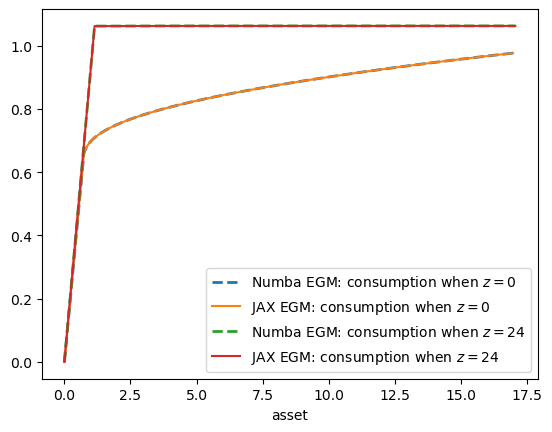

In [14]:
constants, sizes, arrays = model
β, R, γ = constants
s_size, y_size = sizes
s_grid, y_grid, P = arrays


fig, ax = plt.subplots()

for z in (0, y_size-1):
    ax.plot(a_star_egm_nb[:, z], 
            σ_star_egm_nb[:, z], 
            '--', lw=2,
            label=f"Numba EGM: consumption when $z={z}$")
    ax.plot(a_star_egm_jax[:, z], 
            σ_star_egm_jax[:, z], 
            label=f"JAX EGM: consumption when $z={z}$")

ax.set_xlabel('asset')
plt.legend()
plt.show()

### Timing

Now let's compare execution time of the two methods

In [15]:
qe.tic()
a_star_egm_jax, σ_star_egm_jax = successive_approx_jax(model,
                                         print_skip=1000)
jax_time = qe.toc()

Error at iteration 1000 is 6.472028596182788e-05.


Error at iteration 2000 is 1.2994575430580468e-05.



Converged in 2192 iterations.
TOC: Elapsed: 0:00:3.34


In [16]:
qe.tic()
a_star_egm_nb, σ_star_egm_nb = successive_approx_numba(model,
                                         print_skip=1000)
numba_time = qe.toc()

Error at iteration 1000 is 6.472028596182788e-05.


Error at iteration 2000 is 1.2994575430802513e-05.



Converged in 2192 iterations.
TOC: Elapsed: 0:01:18.29


In [17]:
jax_time / numba_time

0.0426930809223618

The JAX code is significantly faster, as expected.

This difference will increase when more features (and state variables) are added
to the model.